In [42]:
import os
import numpy as np
import pickle
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [8]:
BASE_DIR = '/Users/nirajanpaudel17/Documents/Python/image_captioning/archive'
WORKING_DIR = '/Users/nirajanpaudel17/Documents/Python/image_captioning'

In [4]:
model = VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### feature extraction form Images

In [5]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for image_name in tqdm(os.listdir(directory)):  # tqdm is only used for the graphics to displayed while loading images
    image_path = directory + '/' + image_name
    image = load_img(image_path, target_size=(224,224))
    image = img_to_array(image)
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = image_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

2023-11-22 20:47:38.287494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


extracting these features repeatedly is a time consuming process. So it's better to store them in a pickle file.

In [6]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

To load the stored features::
        
        with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
            features = pickle.load(f)

### Load the caption data

In [9]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)  # to avoid the first line of the captions.txt file
    captions_doc = f.read()

#### Creating mapping between images and the captions

In [13]:
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line)<2:
        continue
    
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = ' '.join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [14]:
len(mapping)

8091

##### preprocess the caption 

In [16]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            # remove the special characters, digits...
            caption = caption.replace('[^A-Za-z]', '')
            # remove additional spaces
            caption = caption.replace('\s+', ' ')
            caption = '<start>' + ' '.join([word for word in caption.split() if len(word)>1]) + '<end>'
            captions[i] = caption

In [19]:
mapping['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [20]:
clean(mapping)

In [21]:
mapping['1001773457_577c3a7d70']

['<start>black dog and spotted dog are fighting<end>',
 '<start>black dog and tri-colored dog playing with each other on the road<end>',
 '<start>black dog and white dog with brown spots are staring at each other in the street<end>',
 '<start>two dogs of different breeds looking at each other on the road<end>',
 '<start>two dogs on pavement moving toward each other<end>']

Each image or key in this case has multiple captions. Following code list all the captions in a single dict.

In [22]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [23]:
len(all_captions)

40455

In [31]:
all_captions[:2]

['<start>child in pink dress is climbing up set of stairs in an entry way<end>',
 '<start>girl going into wooden building<end>']

tokenize the corpous "all_captions"

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [27]:
vocab_size

8483

let's calculate the maximum length of the caption which will be required for padding the sequences later

In [33]:
max_length = max(len(caption.split()) for caption in all_captions)

In [34]:
max_length

33

Train Test Split

In [37]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.9)
train = image_ids[:split]
test = image_ids[split:]

Now, we will use the datagenerator to fetch the images and captions in batch

In [55]:
# def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
#     X1, X2, y = list(), list(), list()
#     n=0
#     while 1:
#         for key in data_keys:
#             n+=1
#             captions = mapping[key]
#             for caption in captions:
#                 seq = tokenizer.texts_to_sequences([caption])[0]
#                 for i in range(1, len(seq)):
#                     in_seq, out_seq = seq[:i], seq[i]
#                     in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
#                     out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
#                     X1.append(features[key][0])
#                     X2.append(in_seq)
#                     y.append(out_seq)
#             if n == batch_size:
#                 X1, X2, y = np.array(X1), np.array(X2), np.array(y)
#                 yield [X1,X2],y
#                 X1, X2, y = list(), list(), list()
#                 n=0




def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    n = 0
    while True:
        X1, X2, y = [], [], []
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
                    if n == batch_size:
                        yield [np.array(X1), np.array(X2)], np.array(y)
                        X1, X2, y = [], [], []
                        n = 0


Model Creation

In [56]:
# encoder model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation='relu')(fe1)

# sequence feature layer
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


# decoder model
decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='relu')(decoder2)     # chatgpt suggest the softmax activation 

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot_model(model, show_shapes=True)

In [44]:
!pip install pydot


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [46]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 33)]                 0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 33, 256)              2171648   ['input_8[0][0]']             
                                                                                                  
 dropout_4 (Dropout)         (None, 4096)                 0         ['input_7[0][0]']             
                                                                                            

Train the model

In [58]:
epochs = 15
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 584s 5s/step - loss: 1.1921e-07


In [59]:
model.save(WORKING_DIR + '/first_model.h5')

/Users/nirajanpaudel17/anaconda3/envs/tnfenv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
def index_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

Generate caption for images

In [61]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = '<start>'
    
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        y_hat = model.predict([image, sequence], verbose=0)
        y_hat = np.argmax(y_hat)
        word = index_to_word(y_hat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == '<end>':
            break
    return in_text

validation 

In [70]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.000000
BLEU-2: 0.000000


In [68]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, 'Images', image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('------Actual------')
    for caption in captions:
        print(caption)
        
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('-----Predicted------')
    print(y_pred)
    plt.imshow(image)

------Actual------
<start>blonde horse and blonde girl in black sweatshirt are staring at fire in barrel<end>
<start>girl and her horse stand by fire<end>
<start>girl holding horse 's lead behind fire<end>
<start>"a man and girl and two horses are near contained fire ."<end>
<start>two people and two horses watching fire<end>
-----Predicted------
<start>


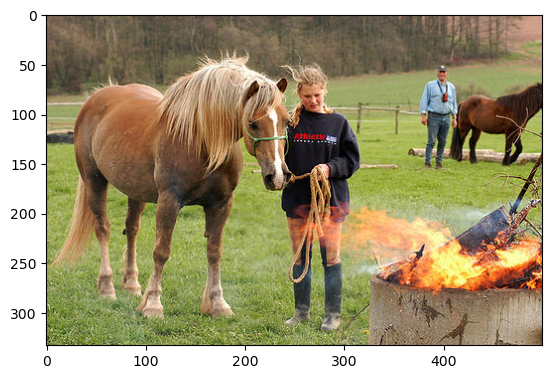

In [69]:
generate_caption('10815824_2997e03d76.jpg')

In [ ]:
# BASE_DIR = '/Users/nirajanpaudel17/Documents/Python/image_captioning/archive'
# WORKING_DIR = '/Users/nirajanpaudel17/Documents/Python/image_captioning'

# model = VGG16()

# model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# features = {}
# directory = os.path.join(BASE_DIR, 'Images')

# for image_name in tqdm(os.listdir(directory)):  # tqdm is only used for the graphics to displayed while loading images
#     image_path = directory + '/' + image_name
#     image = load_img(image_path, target_size=(224,224))
#     image = img_to_array(image)
#     image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
#     image = preprocess_input(image)
#     feature = model.predict(image, verbose=0)
#     image_id = image_name.split('.')[0]
#     features[image_id] = feature

# with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
#     next(f)  # to avoid the first line of the captions.txt file
#     captions_doc = f.read()

# mapping = {}

# for line in tqdm(captions_doc.split('\n')):
#     tokens = line.split(',')
#     if len(line)<2:
#         continue
    
#     image_id, caption = tokens[0], tokens[1:]
#     image_id = image_id.split('.')[0]
#     caption = ' '.join(caption)
#     if image_id not in mapping:
#         mapping[image_id] = []
#     mapping[image_id].append(caption)
    
    
# def clean(mapping):
#     for key, captions in mapping.items():
#         for i in range(len(captions)):
#             caption = captions[i]
#             caption = caption.lower()
#             # remove the special characters, digits...
#             caption = caption.replace('[^A-Za-z]', '')
#             # remove additional spaces
#             caption = caption.replace('\s+', ' ')
#             caption = '<start>' + ' '.join([word for word in caption.split() if len(word)>1]) + '<end>'
#             captions[i] = caption
            
# clean(mapping)

# all_captions = []
# for key in mapping:
#     for caption in mapping[key]:
#         all_captions.append(caption)
        
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(all_captions)
# vocab_size = len(tokenizer.word_index) + 1

# max_length = max(len(caption.split()) for caption in all_captions)

# image_ids = list(mapping.keys())
# split = int(len(image_ids) * 0.9)
# train = image_ids[:split]
# test = image_ids[split:]

# def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
#     X1, X2, y = list(), list(), list()
#     n=0
#     while 1:
#         for key in data_keys:
#             n+=1
#             captions = mapping[key]
#             for caption in captions:
#                 seq = tokenizer.texts_to_sequences([caption])[0]
#                 for i in range(1, len(seq)):
#                     in_seq, out_seq = seq[:i], seq[i]
#                     in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
#                     out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
#                     X1.append(features[key][0])
#                     X2.append(in_seq)
#                     y.append(out_seq)
#             if n == batch_size:
#                 X1, X2, y = np.array(X1), np.array(X2), np.array(y)
#                 yield [X1,X2],y
#                 X1, X2, y = list(), list(), list()
#                 n=0
                

# # encoder model
# inputs1 = Input(shape=(4096,))
# fe1 = Dropout(0.4)(inputs1)
# fe2 = Dense(256,activation='relu')(fe1)

# # sequence feature layer
# inputs2 = Input(shape=(max_length,))
# se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# se2 = Dropout(0.4)(se1)
# se3 = LSTM(256)(se2)

# # decoder model
# decoder1 = add([fe2,se3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='relu')(decoder2)     # chatgpt suggest the softmax activation 

# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot_model(model, show_shapes=True)

# epochs = 15
# batch_size = 64
# steps = len(train) // batch_size

# for i in range(epochs):
#     generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#     model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
